In [1]:
import tensorflow as tf
import tools.datasets.mnist as mnist_tools
import tools.semisup as semisup
import numpy as np
import architectures as arch
from functools import partial

import tools.visualization as vis
import tools.updated_semisup as up

%load_ext autoreload
%autoreload 2

import sys

mnist_train_images, mnist_train_labels = mnist_tools.get_data('train')
mnist_test_images, mnist_test_labels = mnist_tools.get_data('test')
mnistu_train_images, mnistu_train_labels = mnist_tools.get_data('train')
mnistu_test_images, mnistu_test_labels = mnist_tools.get_data('test')

/home/frankzl/.envs/env36-ml/.venv/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


Extracting /home/frankzl/datasets/mnist//train-images-idx3-ubyte.gz
Extracting /home/frankzl/datasets/mnist//train-labels-idx1-ubyte.gz
Extracting /home/frankzl/datasets/mnist//t10k-images-idx3-ubyte.gz
Extracting /home/frankzl/datasets/mnist//t10k-labels-idx1-ubyte.gz
Extracting /home/frankzl/datasets/mnist//train-images-idx3-ubyte.gz
Extracting /home/frankzl/datasets/mnist//train-labels-idx1-ubyte.gz
Extracting /home/frankzl/datasets/mnist//t10k-images-idx3-ubyte.gz
Extracting /home/frankzl/datasets/mnist//t10k-labels-idx1-ubyte.gz


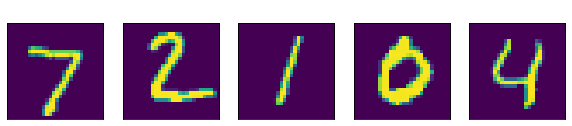

In [2]:
vis.imshow(mnistu_test_images[0:5], channels=1, imgwidth=28)

In [3]:
def mnist_model(inputs,
                is_training=True,
                emb_size=128,
                l2_weight=1e-3,
                batch_norm_decay=None,
                img_shape=None,
                new_shape=None,
                augmentation_function=None,
                image_summary=False):  # pylint: disable=unused-argument

    """Construct the image-to-embedding vector model."""

    inputs = tf.cast(inputs, tf.float32) / 255.0
    if new_shape is not None:
        shape = new_shape
        inputs = tf.image.resize_images(
            inputs,
            tf.constant(new_shape[:2]),
            method=tf.image.ResizeMethod.BILINEAR)
    else:
        shape = img_shape
    net = inputs
    with slim.arg_scope(
            [slim.conv2d, slim.fully_connected],
            activation_fn=tf.nn.elu,
            weights_regularizer=slim.l2_regularizer(l2_weight)):
        temp = net
        net = slim.conv2d(net, 32, [3, 3], scope='conv1_1')
        net = slim.conv2d(net, 32, [3, 3], scope='conv1_2')
        net = slim.max_pool2d(net, [2, 2], scope='pool1')  # 14
        

        net = slim.conv2d(net, 64, [3, 3], scope='conv2_1')
        net = slim.conv2d(net, 64, [3, 3], scope='conv2_2')
        net = slim.max_pool2d(net, [2, 2], scope='pool2')  # 7

        net = slim.conv2d(net, 128, [3, 3], scope='conv3_1')
        net = slim.conv2d(net, 128, [3, 3], scope='conv3_2')
        net = slim.max_pool2d(net, [2, 2], scope='pool3')  # 3

        net = slim.flatten(net, scope='flatten')
        emb = slim.fully_connected(net, emb_size, scope='fc1')
    return emb

In [17]:
# labeled samples used per class
# sup_per_class = 10
sup_per_class = 10
sup_seed = -1
# labeled samples per class per batch
sup_per_batch = 10
# unlabeled samples per batch
unsup_batch_size = 500
unsup_samples = -1

learning_rate = 1e-4
decay_steps = 5000
decay_factor = 0.33
logit_weight = 1.0

max_steps = 1500
eval_interval = 500

seed = 1

IMAGE_SHAPE = mnist_tools.IMAGE_SHAPE
NUM_LABELS = mnist_tools.NUM_LABELS

# [10 (classes), 10 (samples), 28, 28, 1]
sup_by_label = semisup.sample_by_label(mnist_train_images, mnist_train_labels,
                        sup_per_class, NUM_LABELS, seed)

visit_weight_envelope = "linear"
visit_weight = 1
visit_weight_envelope_steps = 1
visit_weight_envelope_delay = 500

walker_weight_envelope = "linear"
walker_weight = 1
walker_weight_envelope_steps = 1
walker_weight_envelope_delay = 500

TARGET_SHAPE = mnist_tools.IMAGE_SHAPE
TEST_SHAPE   = TARGET_SHAPE

image_shape = IMAGE_SHAPE
new_shape   = TARGET_SHAPE
emb_size    = 128

sampled_unsup_images = mnistu_train_images
sampled_unsup_labels = mnistu_train_labels

In [18]:
from ipywidgets import IntProgress, Layout
from train import apply_envelope
import tensorflow.contrib.slim as slim

store_dir = "logs/training/mnist-mnist-K-s5/model"
graph = tf.Graph()


with graph.as_default():
    
    unsup_data = up.create_input(sampled_unsup_images, sampled_unsup_labels, unsup_batch_size)
    unsup_it   = unsup_data.make_initializable_iterator()
    
    t_unsup_images,t_unsup_labels = unsup_it.get_next()
    
    sup_data,sup_label = up.create_per_class_inputs_v2(sup_by_label, sup_per_batch)
    sup_it             = sup_data.repeat().make_one_shot_iterator()
    sup_it_label       = sup_label.repeat().make_one_shot_iterator()
    
    
    model = semisup.SemisupModel(mnist_model, NUM_LABELS, IMAGE_SHAPE)
    
    t_sup_images, t_sup_labels = tf.concat( sup_it.get_next(), 0), tf.concat( sup_it_label.get_next(), 0)
    
    t_sup_emb   = model.image_to_embedding(t_sup_images)
    
    t_unsup_emb = model.image_to_embedding(t_unsup_images)
    
    t_sup_logit = model.embedding_to_logit(t_sup_emb)
    
    visit_weight = apply_envelope(
        type = visit_weight_envelope,
        step = model.step,
        final_weight = visit_weight,
        growing_steps = visit_weight_envelope_steps,
        delay = visit_weight_envelope_delay
    )
    
    walker_weight = apply_envelope(
        type = walker_weight_envelope,
        step = model.step,
        final_weight = walker_weight,
        growing_steps = walker_weight_envelope_steps,
        delay = walker_weight_envelope_delay
    )
    
    tf.summary.scalar("Weights_Visit", visit_weight)
    tf.summary.scalar("Weight_Walker", walker_weight)
    
    model.add_logit_loss(t_sup_logit, t_sup_labels, weight=logit_weight)
    
    #model.add_semisup_loss(t_sup_emb, t_unsup_emb, t_sup_labels, visit_weight=visit_weight, walker_weight=walker_weight)
    equality_matrix = tf.equal(tf.reshape(t_sup_labels, [-1, 1]), t_sup_labels)
    equality_matrix = tf.cast(equality_matrix, tf.float32)
    p_target = (equality_matrix / tf.reduce_sum(
        equality_matrix, [1], keepdims=True))
    

    
    embedding_dim = t_sup_emb.shape[1]
    reshaped_semb = tf.reshape( t_sup_emb, [-1, 1, embedding_dim] )
    reshaped_uemb = tf.reshape( t_unsup_emb, [-1, 1, embedding_dim] )
    
    stacked_semb = tf.stack(unsup_batch_size*[t_sup_emb], 1)
    stacked_uemb = tf.stack(sup_per_batch*NUM_LABELS*[t_unsup_emb], 1)
    
    uemb_T = tf.transpose(stacked_uemb, perm=[1,0,2])
     
    sigma = 5
    
    pairwise_dist = (stacked_semb - uemb_T)#, axis=2)
    #pairwise_norm = tf.norm( pairwise_dist, axis=2)
    #pairwise_sq   = tf.square(pairwise_norm)
    
    pairwise_sq  = tf.reduce_sum( tf.math.square(pairwise_dist), axis=2)
    
    match_ab   = tf.exp(- tf.divide( pairwise_sq, tf.constant(2*sigma**2, dtype=tf.float32)), name='match_ab')
    
    p_ab = tf.nn.softmax(match_ab, name='p_ab')
    p_ba = tf.nn.softmax(tf.transpose(match_ab), name='p_ba')
    p_aba = tf.matmul(p_ab, p_ba, name='p_aba')

    model.create_walk_statistics(p_aba, equality_matrix)
    
    aba_logits = tf.log(1e-8 + p_aba)
    
    loss_aba = tf.losses.softmax_cross_entropy(
        p_target,
        aba_logits,
        weights=walker_weight,
        scope='loss_aba')
    
    model.add_visit_loss(p_ab, visit_weight)

    #dt_semb, dt_uemb = tf.gradients([loss_aba], [p_aba, t_unsup_emb])
    #mab_dt, pab_dt, paba_dt, semb_dt, uemb_dt = tf.gradients([loss_aba], [match_ab, p_ab, p_aba, t_sup_emb, t_unsup_emb])
    semb_dt, uemb_dt = tf.gradients([match_ab], [t_sup_emb, t_unsup_emb])
    
    tf.summary.scalar('Loss_aba', loss_aba)
    
    t_learning_rate = tf.train.exponential_decay(
        learning_rate,
        model.step,
        decay_steps,
        decay_factor,
        staircase = True
    )
    
    train_op = model.create_train_op(t_learning_rate)
    summary_op = tf.summary.merge_all()
    
    summary_writer = tf.summary.FileWriter(store_dir, graph)
    
    saver = tf.train.Saver(max_to_keep=30)

---------
Variables: name (type shape) [size]
---------
net/conv1_1/weights:0 (float32_ref 3x3x1x32) [288, bytes: 1152]
net/conv1_1/biases:0 (float32_ref 32) [32, bytes: 128]
net/conv1_2/weights:0 (float32_ref 3x3x32x32) [9216, bytes: 36864]
net/conv1_2/biases:0 (float32_ref 32) [32, bytes: 128]
net/conv2_1/weights:0 (float32_ref 3x3x32x64) [18432, bytes: 73728]
net/conv2_1/biases:0 (float32_ref 64) [64, bytes: 256]
net/conv2_2/weights:0 (float32_ref 3x3x64x64) [36864, bytes: 147456]
net/conv2_2/biases:0 (float32_ref 64) [64, bytes: 256]
net/conv3_1/weights:0 (float32_ref 3x3x64x128) [73728, bytes: 294912]
net/conv3_1/biases:0 (float32_ref 128) [128, bytes: 512]
net/conv3_2/weights:0 (float32_ref 3x3x128x128) [147456, bytes: 589824]
net/conv3_2/biases:0 (float32_ref 128) [128, bytes: 512]
net/fc1/weights:0 (float32_ref 1152x128) [147456, bytes: 589824]
net/fc1/biases:0 (float32_ref 128) [128, bytes: 512]
net/fully_connected/weights:0 (float32_ref 128x10) [1280, bytes: 5120]
net/fully_c

In [19]:
import time
import datetime
test_images = mnistu_test_images[:2000]
test_labels = mnistu_test_labels[:2000]
store_dir

'logs/training/mnist-mnist-K-s5/model'

In [8]:
from IPython.display import display

max_steps = 1502
f = IntProgress(min=0, max=max_steps, layout= Layout(width="100%")) # instantiate the bar
display(f) # display the bar

sesh = tf.Session(graph = graph, config=tf.ConfigProto(intra_op_parallelism_threads=2, allow_soft_placement=True))

eval_interval = 100

p_aba_list = []
match_ab_list = []
t_sup_emb_list = []
t_unsup_emb_list = []
losses = []


with sesh as sess:
    
    sess.run(unsup_it.initializer)
    sess.run(tf.global_variables_initializer())
    
    epoch = 0
    vars = tf.trainable_variables()
    
    for step in range(0, max_steps):
        t0 = time.time()
        try:
            #vars_vals = sess.run(vars)
            loss, _, summaries = sess.run([model.train_loss, train_op, summary_op])
        except tf.errors.OutOfRangeError:
            sess.run(unsup_it.initializer)
            epoch += 1
            loss, _, summaries = sess.run([model.train_loss, train_op, summary_op])
        
        losses.append(loss)
           
        f.value = step
        f.description = f"Ep{epoch}:{step}/{max_steps}"
        if (step) % eval_interval == 0:
            
            t1 = time.time()
            print(f"Time left: {datetime.timedelta(seconds=int((t1-t0)*(max_steps-step)))}s")
            
            print('Step: %d' % step)
            test_pred = model.classify(test_images).argmax(-1)
            conf_mtx = semisup.confusion_matrix(test_labels, test_pred, NUM_LABELS)
            test_err = (test_labels != test_pred).mean() * 100
            print(conf_mtx)
            print('Test error: %.2f %%' % test_err)
            print(f'Loss: {loss}')
            print()
    
            test_summary = tf.Summary(
                value=[tf.Summary.Value(
                    tag='Test Err', simple_value=test_err)])
    
            summary_writer.add_summary(summaries, step)
            summary_writer.add_summary(test_summary, step)

            print(f"saving model - step {step}")
            saver.save(sess, store_dir, global_step=model.step)

IntProgress(value=0, layout=Layout(width='100%'), max=1502)

Time left: 1:34:44s
Step: 0
[[ 18   2   0  87   0   9  59   0   0   0]
 [  8  42   0  16   0   0 149  19   0   0]
 [ 36  59   4  65   0  13  42   0   0   0]
 [ 50  27   0  36   0  10  84   0   0   0]
 [ 28  19   0  32   0   4 130   0   0   4]
 [ 34   6   0  36   0   3  98   0   0   2]
 [  8  25   1  53   0   1  90   0   0   0]
 [ 37  14   0   7   0   0 137   2   0   8]
 [ 28  24   0  48   0   1  91   0   0   0]
 [ 10  33   0  28   0   1 117   1   0   4]]
Test error: 90.05 %
Loss: 2.604328155517578

saving model - step 0
Time left: 1:21:51s
Step: 100
[[148   0  10   2   0   4   4   1   6   0]
 [  0 197   1  35   0   0   1   0   0   0]
 [  0   0 171  25   3   0   8   3   8   1]
 [  2   1   3 165   0   5   1   5  19   6]
 [  0   0   1   0 144   0  17   4   2  49]
 [  9   3   2  13   2 116   8   3  10  13]
 [  6   2   4   0   2   1 158   1   4   0]
 [  0   4   5  42   2   0   0 125  17  10]
 [  6   1   2  17   0   2   5   2 152   5]
 [  0   0   0   4   3   0   0   8   7 172]]
Test error: 2

In [21]:
with tf.Session(graph=graph) as sess:
    saver = tf.train.Saver()
    
    model_checkpoint = f"{store_dir}-{601}"
    saver.restore(sess, model_checkpoint)
    sess.run(unsup_it.initializer)
    
    semb, slabel, uemb, ulabel, sdt,udt = sess.run([t_sup_emb, t_sup_labels, t_unsup_emb, t_unsup_labels, semb_dt, uemb_dt ])

INFO:tensorflow:Restoring parameters from logs/training/mnist-mnist-K-s5/model-601


In [28]:
#np.mean(sdt, axis=0)
#np.mean(sdt, axis=0)

",".join([f"{i:.3f}" for i in list(np.mean(sdt, axis=0))])

'-0.053,-0.082,-0.051,-0.012,-0.122,-0.019,0.122,-0.036,0.120,-0.070,-0.101,0.177,0.102,-0.051,-0.030,0.067,0.048,-0.005,0.047,0.080,0.098,0.067,-0.082,-0.039,-0.080,0.019,0.101,-0.154,0.027,0.069,0.161,-0.101,-0.161,-0.047,-0.247,-0.113,-0.000,-0.015,0.102,0.060,0.048,-0.017,-0.107,-0.056,0.048,0.046,0.042,-0.140,-0.068,-0.106,0.046,-0.039,0.045,-0.015,0.054,-0.034,-0.070,-0.061,-0.029,0.077,-0.119,0.114,0.018,-0.039,-0.099,-0.043,-0.089,0.017,0.018,0.112,-0.016,0.032,-0.028,-0.038,0.069,0.185,-0.014,0.005,-0.028,-0.009,0.089,-0.087,0.160,-0.021,-0.057,0.069,-0.009,-0.057,0.095,-0.073,-0.002,-0.101,0.093,-0.138,-0.107,0.050,0.092,0.212,0.084,-0.017,-0.036,-0.042,0.104,-0.023,0.102,-0.036,-0.119,0.066,-0.027,-0.075,-0.000,0.004,0.113,-0.009,-0.002,-0.003,0.035,-0.079,0.123,0.023,-0.129,-0.131,-0.092,-0.125,0.055,-0.070,0.139,-0.033'

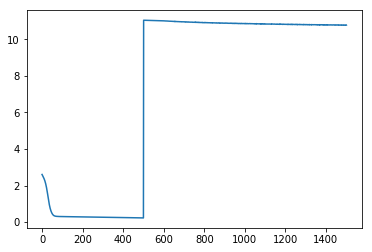

In [10]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [21]:
f"{loss:.3f}"

'10.778'

In [29]:
text = "\n".join([f"{it},{loss:.3f}" for it, loss in enumerate(losses)])

with open("Output.txt", "w") as text_file:
    text_file.write(text)

In [31]:
sembs = []
slabels = []
uembs = []
ulabels = []
similarities = []

for i in range(1, 1502, 100):
    with tf.Session(graph=graph) as sess:
        saver = tf.train.Saver()
        
        model_checkpoint = f"{store_dir}-{i}"
        saver.restore(sess, model_checkpoint)
        sess.run(unsup_it.initializer)
        
        semb, slabel, uemb, ulabel = sess.run([t_sup_emb, t_sup_labels, t_unsup_emb, t_unsup_labels])
        sembs.append(semb)
        uembs.append(uemb)
        slabels.append(slabel)
        ulabels.append(ulabel)
        stacked = np.vstack([semb, uemb[ulabel.argsort()]])
        stacked_similarity = stacked @ stacked.T
        similarities.append(stacked_similarity)

INFO:tensorflow:Restoring parameters from logs/training/mnist-mnist-K-s5/model-1
INFO:tensorflow:Restoring parameters from logs/training/mnist-mnist-K-s5/model-101
INFO:tensorflow:Restoring parameters from logs/training/mnist-mnist-K-s5/model-201
INFO:tensorflow:Restoring parameters from logs/training/mnist-mnist-K-s5/model-301
INFO:tensorflow:Restoring parameters from logs/training/mnist-mnist-K-s5/model-401
INFO:tensorflow:Restoring parameters from logs/training/mnist-mnist-K-s5/model-501
INFO:tensorflow:Restoring parameters from logs/training/mnist-mnist-K-s5/model-601
INFO:tensorflow:Restoring parameters from logs/training/mnist-mnist-K-s5/model-701
INFO:tensorflow:Restoring parameters from logs/training/mnist-mnist-K-s5/model-801
INFO:tensorflow:Restoring parameters from logs/training/mnist-mnist-K-s5/model-901
INFO:tensorflow:Restoring parameters from logs/training/mnist-mnist-K-s5/model-1001
INFO:tensorflow:Restoring parameters from logs/training/mnist-mnist-K-s5/model-1101
INFO

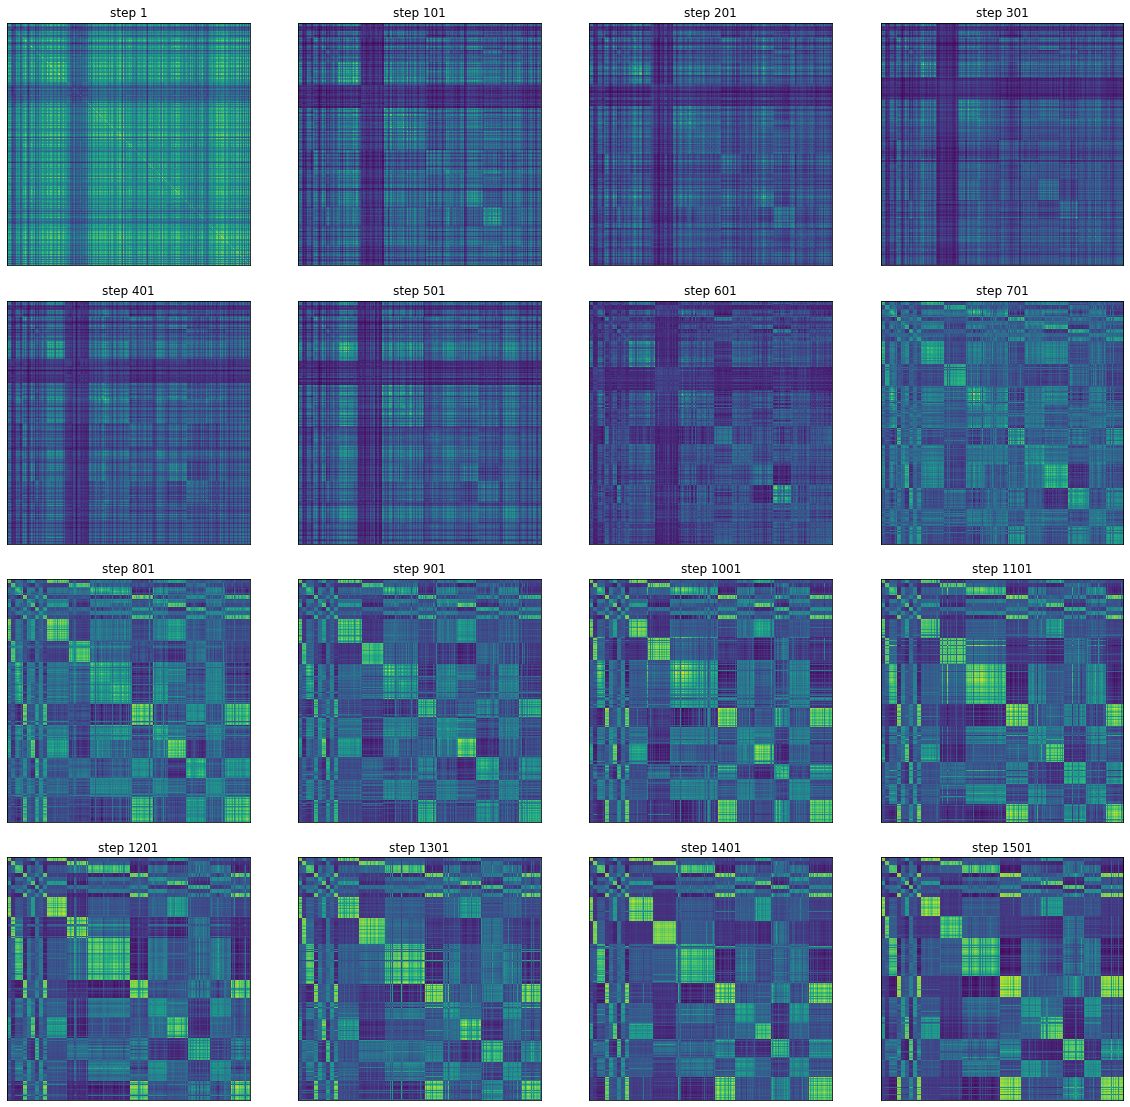

In [32]:
vis.imshow(similarities, labels=[f"step {i}" for i in list(range(1,1502, 100))], imgwidth=600, num_row=4, figsize=(20,20), hspace=0.1)

In [33]:
stacked = np.vstack([sembs[5], uembs[5][ulabels[5].argsort()]])

In [43]:
import tools.analyzer as ana

imgs = []

for i in range(5,len(sembs)):
    stacked = np.vstack([sembs[i], uembs[i][ulabels[i].argsort()]])
    kg5 = ana.get_pairwise_distance(stacked, ana.Distance.get_gaussian_k(sigma=5))
    
    imgs.append(kg5)
    print(i, end=",")

5,6,7,8,9,10,11,12,13,14,15,

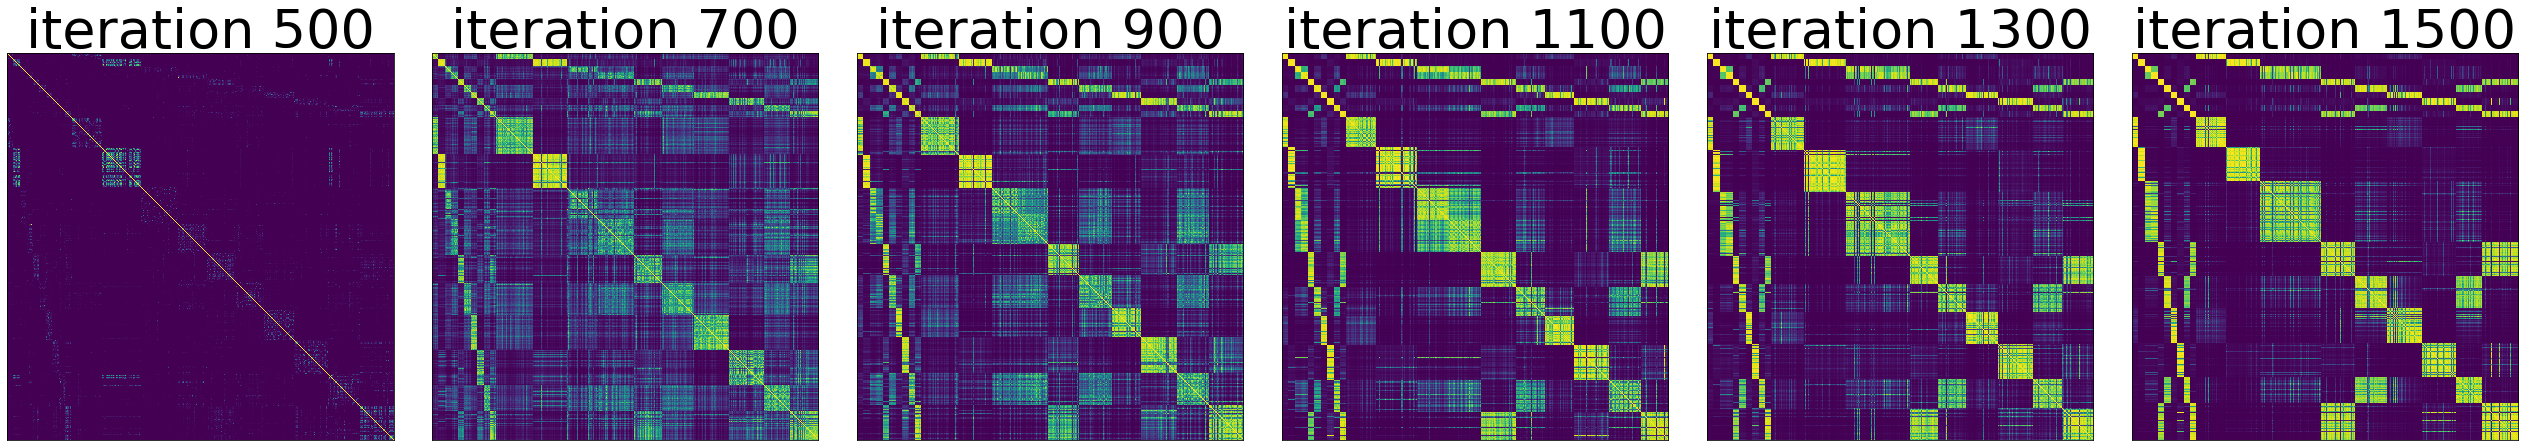

In [69]:
import matplotlib
matplotlib.rcParams.update({'font.size': 45})

vis.imshow(imgs[::2], imgwidth=600, num_row=6, figsize=(45,8), hspace=0, wspace=0.1, labels=[f"iteration {i}" for i in range(500,1502,200)])
plt.set_cmap(plt.cm.viridis)
plt.savefig("kernelizedmnist.svg")

In [52]:
x=list(range(10))

In [56]:
[f"iteration {i}" for i in range(500,1502,200)]

['iteration 500',
 'iteration 700',
 'iteration 900',
 'iteration 1100',
 'iteration 1300',
 'iteration 1500']